## Recreate Table S5, Figures 3B and 5B

In [15]:
library(stringr)
library(ggplot2)
library(circlize)

In [3]:
dir <- "~/Downloads/Aug20_BLZ_data/"

## Read in and compile cellphonedb output & annotated gene lists

In [4]:
# read in pvalue tables
p.blz <- read.table(file.path(dir, "pvalues.txt"),
                    sep='\t', header=T, stringsAsFactors=F)
p.ctl <- read.table(file.path(dir, "pvalues.txt"),
                    sep='\t', header=T, stringsAsFactors=F)

rownames(p.blz) <- p.blz$interacting_pair
rownames(p.ctl) <- p.ctl$interacting_pair

In [5]:
# read in means
m.blz <- read.table(file.path(dir, "means.txt"),
                    sep='\t', header=T, stringsAsFactors=F)
m.ctl <- read.table(file.path(dir, "means.txt"),
                    sep='\t', header=T, stringsAsFactors=F)

rownames(m.blz) <- m.blz$interacting_pair
rownames(m.ctl) <- m.ctl$interacting_pair

In [6]:
# read in significant means
sm.blz <- read.table(file.path(dir, "significant_means.txt"),
                     sep='\t', header=T, stringsAsFactors=F)
sm.ctl <- read.table(file.path(dir, "significant_means.txt"),
                    sep='\t', header=T, stringsAsFactors=F)

In [7]:
p.blz.ctl <- merge(p.blz[,-c(1, 3:11)], p.ctl[,-c(1, 3:11)], 
                   by="interacting_pair")

m.blz.ctl <- merge(m.blz[,-c(1, 3:11)], m.ctl[,-c(1, 3:11)], 
                   by="interacting_pair")

In [8]:
# update - import annotated activating/inhibitory gene pairs with cell type specificity
ACTIV_GENES <- read.table(file.path(dir, "Activating_List.txt"),
                          sep="\t", header=T, stringsAsFactors=F)[,c(1:2)]

INHIB_GENES <- read.table(file.path(dir, "Inhibitory_List.txt"),
                          sep="\t", header=T, stringsAsFactors=F)[,c(1:2)]

ACTIV_GENES$concat <- paste(ACTIV_GENES$Ligand.receptor.pair, 
                            ACTIV_GENES$Interacting.cell.types, sep="-")
INHIB_GENES$concat <- paste(INHIB_GENES$Ligand.receptor.pair, 
                            INHIB_GENES$Interacting.cell.types, sep="-")

In [34]:
# function for making mini dataframe for interacting pairs
pseudo <- 0.5

MakeMiniDf <- function (mean_data, data, int_pair_col, col1, col2, names, sign) {
  # get means for ctl and blz
  m.t <- mean_data[(mean_data[,int_pair_col] %in% data[,int_pair_col]),][,c(1,col1,col2)]
  # calculate FC (Blz/Ctl)
  m.t$FC <- (m.t[,2]+pseudo)/(m.t[,3]+pseudo)
  # determine direction of FC
  m.t$dir <- "DOWN"
  m.t$dir[m.t$FC>1] <- "UP"
  # get p-values
  m.t$pBLZ <- data[,2]
  m.t$pCTL <- data[,3]
  # record name of interacting cell types
  m.t$pair <- substr(names[1], 1, nchar(names[1])-2)
  
  # LR must be expressed >1 in either BLZ or Ctl
  if (sign==1) {
    m.t <- m.t[m.t[,2]>1,]
  }
  else {
    m.t <- m.t[m.t[,3]>1,]
  }
  # record means 
  m.t$mBLZ <- m.t[,2]
  m.t$mCTL <- m.t[,3]
  # get rid of original means with non-standard column names
  m.t <- m.t[-c(2,3)]
  return(m.t)
}

In [35]:
# define pairs of interest - DC1/2/3, T/NK
pairlist <- list(c("DC1.T.x", "DC1.T.y"), c("T.DC1.x", "T.DC1.y"),
                 c("DC2.T.x", "DC2.T.y"), c("T.DC2.x", "T.DC2.y"),
                 c("DC3.T.x", "DC3.T.y"), c("T.DC3.x", "T.DC3.y"),
                 c("DC1.NK.cells.x", "DC1.NK.cells.y"), 
                 c("NK.cells.DC1.x", "NK.cells.DC1.y"),
                 c("DC2.NK.cells.x", "DC2.NK.cells.y"), 
                 c("NK.cells.DC2.x", "NK.cells.DC2.y"),
                 c("DC3.NK.cells.x", "DC3.NK.cells.y"), 
                 c("NK.cells.DC3.x", "NK.cells.DC3.y"))

### Label up- and down-regulated interactions

In [36]:
# initialize empty lists and counter 
compiled_up <- list()
compiled_down <- list()
up_count <- 1
down_count <- 1

for (x in pairlist) {
  # get column numbers
  c1 <- match(x[1],names(p.blz.ctl))
  c2 <- match(x[2],names(p.blz.ctl))
  # get interactions that are significant in blz and mean expression increases from ctl
  a <- p.blz.ctl[((p.blz.ctl[,c1]<0.05) & (m.blz.ctl[,c1]>m.blz.ctl[,c2])),][,c(1,c1,c2)]
  # get interactions that lost significance in blz (significant in ctl), with mean expression decreasing from ctl
  c <- p.blz.ctl[((m.blz.ctl[,c1]<m.blz.ctl[,c2]) & (p.blz.ctl[,c2]<0.05)),][,c(1,c1,c2)]
  if (nrow(a) > 0){
    compiled_up[[up_count]] <- MakeMiniDf(m.blz.ctl, a, 1, c1, c2, x, 1)
    up_count <- up_count + 1
  }
  if (nrow(c) > 0){
    compiled_down[[down_count]] <- MakeMiniDf(m.blz.ctl, c, 1, c1, c2, x, 0)
    down_count <- down_count + 1
  }
}

### Label activating and inhibitory interactions

In [37]:
# format mini DF --> label activating and inhibitory interactions
FormatMiniDf <- function(compiled, up, down) {
  # vertically concat
  all = do.call(rbind, compiled)
  # reformat NK cells text
  all$pair <- gsub(".cells", "", all$pair)  
  # # order in FC order
  # all <- all[order(-abs(all$FC)),]
  # # reset row names
  # row.names(all) <- seq(1, nrow(all),1)
  # add column to mark interesting interactions
  all$concat <- paste(all$interacting_pair, all$pair, sep="-")  
  all$fn <- ""
  all$fn[all$concat %in% up] <- "A" 
  all$fn[all$concat %in% down] <- "I"
  all$name <- ""
  all$name[all$concat %in% c(up,down)] <- paste0(str_replace(all$interacting_pair[all$concat %in% c(up,down)], "_", "."), 
                                               "_", all$pair[all$concat %in% c(up,down)])
  return(all)
}

In [38]:
# # specify interesting interactions - up
all <- FormatMiniDf(compiled_up, ACTIV_GENES$concat, INHIB_GENES$concat)

# interesting interactions - down
# all <- FormatMiniDf(compiled_down, ACTIV_GENES$concat, INHIB_GENES$concat)

## Write all up- and down-regulated interactions to file (Table S5)

In [39]:
all <- all_up

outdir <- "~/Downloads/Aug20_BLZ_data/"
fname <- "Interactions_UP-DC1-3_Aug20.txt"

In [40]:
# # combine T and NK
all$pair <- gsub("T", "NK", all$pair)
all$pair <- gsub("NK", "NK/T", all$pair)
# all$pair <- gsub("NK.cells", "NK", all$pair)   # maintain separate NK and T for interaction table

# separate cell types and L/R
all$c1 <- sapply(strsplit(all$pair, split = "[.]"), `[[`, 1)
all$c2 <- sapply(strsplit(all$pair, split = "[.]"), `[[`, 2)
all$l1 <- sapply(strsplit(all$interacting_pair, split = "_"), `[[`, 1)
all$r1 <- sapply(strsplit(all$interacting_pair, split = "_"), `[[`, 2)
clusters <- unique(all$c1)
pairs <- list(c("DC1.NK/T", "NK/T.DC1"),
              c("DC2.NK/T", "NK/T.DC2"),
              c("DC3.NK/T", "NK/T.DC3"))

all_both <- all

In [41]:
### select one or the other filter - less than 10% p-value ### 
sm_pass <- sm.blz[(sm.blz$rank<0.1),]$interacting_pair ## for up in blz
# sm_pass <- sm.ctl[(sm.ctl$rank<0.1),]$interacting_pair  ## for up in ctl

# ## apply filter
pass <- intersect(sm_pass, all$interacting_pair) ## gives set of interactions significant in 10% of blz pairs
all <- all[(all$interacting_pair %in% pass),]

# ### filter for FC ###
all <- all[all$FC>=1.15,]
# all <- all[all$FC<=(1/1.15),]


## Make circos plots (Figures 3B, 5B)  

Note: 1 point is out of plotting region in sector 'DC1', track '1'.

Note: 1 point is out of plotting region in sector 'DC2', track '1'.

Note: 1 point is out of plotting region in sector 'DC3', track '1'.

Note: 1 point is out of plotting region in sector 'NK/T', track '1'.



null device 
          1

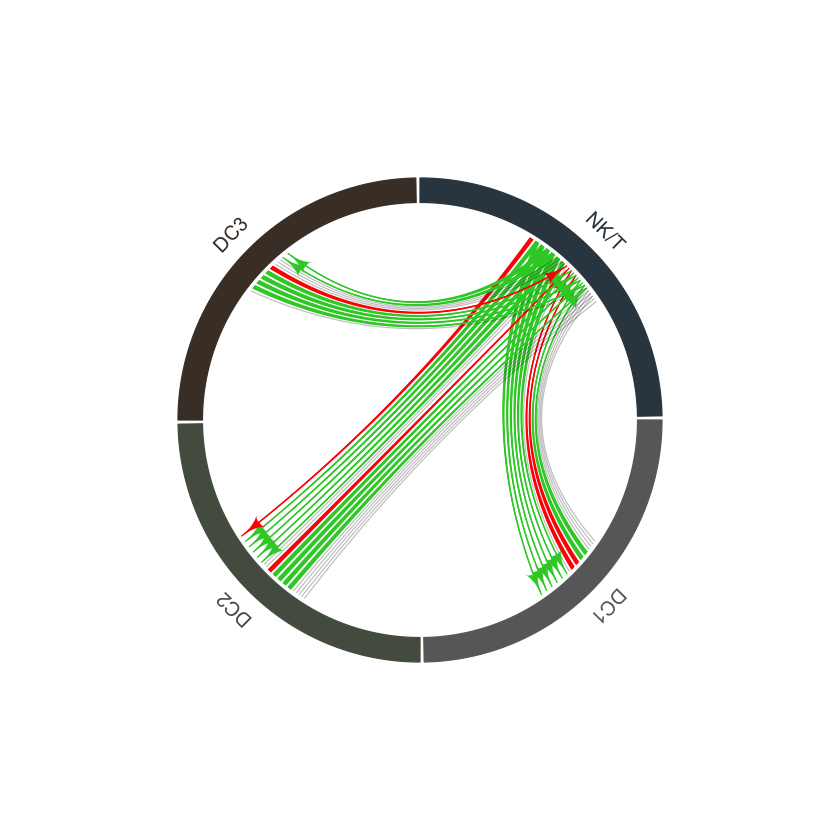

In [42]:
# get unique ligands and receptors
ligands <- all$l1
receptors <- all$r1
num.lig.rec <- length(unique(c(ligands, receptors)))

# initialize and populate "circos.data" matrix
circos.data <- data.frame(matrix(data = 0, nrow = length(clusters) *
                                   num.lig.rec, ncol = 2))
colnames(circos.data) <- c("cell.type", "genes")
seq1 <- seq(1, num.lig.rec * length(clusters), num.lig.rec)
seq2 <- seq(num.lig.rec, num.lig.rec * length(clusters) +
              1, num.lig.rec)
for (i in 1:length(seq2)) {
  circos.data[seq1[i]:seq2[i], 1] <- clusters[i]
  circos.data[seq1[i]:seq2[i], 2] <- unique(c(ligands, receptors))
}

# set order of sectors
circos.data$cell.type <- factor(circos.data$cell.type, c("DC1", "DC2", "DC3", "NK/T"))

# set colors
GREEN = "#32CD32"   # limegreen
BLACK = "#00000040"
colors = c("#696969", "#555D50", "#483C32", "#36454F")

pdf(file.path(dir, "Circos-UP_DC1-3_FC+P_updated-21.01.15.pdf"), 
    width=7, height=7)
circos.par(cell.padding = c(0, 0, 0, 0), track.height = 0.1, canvas.xlim=c(-1.5,1.5))
circos.initialize(factors = circos.data$cell.type, xlim=c(0,1))
circos.track(factors = circos.data$cell.type, ylim = c(0, 1), bg.col=colors, 
             bg.border=colors, panel.fun = function(x, y) {
  circos.text(CELL_META$xcenter, CELL_META$cell.ylim[2] + 
                uy(5, "mm"), CELL_META$sector.index, col=colors[CELL_META$sector.numeric.index])
})
for (i in 1:length(pairs)) {
  link.1 <- strsplit(pairs[[i]][1], split = "[.]")[[1]][1]
  link.2 <- strsplit(pairs[[i]][1], split = "[.]")[[1]][2]
  
  links <- all[all$pair %in% pairs[[i]],]
  links <- links[with(links, order(c1, fn)),]
  nlinks <- nrow(links)
  nspec <- nrow(links[(nchar(links$name)>0),])
 
  if (nlinks > 0) {
    n = 0.5-round((nlinks+nspec)/2)/100
    m = 0.5+round((nlinks+nspec)/2)/100
    spct = 0
    for (i in 1:nlinks) {
      # if interaction is flagged, color and make line thicker
      if (nchar(links[i,]$name) > 0) {
        if (link.1 == links[i,]$c1) {
          # circos.link(link.1, c(n+(i+spct)/100, n+(i+spct+1)/100), link.2, c(m-(i+spct)/100, m-(i+spct+1)/100),
          #             h.ratio = 0.7, col="red", directional=1)
          # circos.link(link.1, c(n+(i+spct)/100, n+(i+spct+1)/100), link.2, c(m-(i+spct)/100, m-(i+spct+1)/100),
          color=GREEN
          if (links[i,]$fn == "I") { color="red" }
          circos.link(link.1, c(n+(i+spct)/100, n+(i+spct+1)/100), link.2, c(m-(i+spct)/100),
                        h.ratio = 0.7, col=color, directional=1, arr.type="curved")
        }
        else {
          color=GREEN
          if (links[i,]$fn == "I") { color="red" }
          circos.link(link.1, c(n+(i+spct)/100), link.2, c(m-(i+spct)/100, m-(i+spct+1)/100),
                        h.ratio = 0.7, col=color, directional=-1, arr.type="curved")
        }
        spct = spct + 1
        # else draw in default thickness black line  
      } else {
        circos.link(link.1, n+(i+spct)/100, link.2, m-(i+spct)/100, h.ratio = 0.7, col=BLACK)
      }
    }
  }
}
dev.off()
circos.clear()